In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import StandardScaler, OneHotEncoder, \
FunctionTransformer, normalize, PolynomialFeatures, LabelEncoder

from sklearn.linear_model import LinearRegression, LogisticRegression, \
Ridge, Lasso, ElasticNet, LassoCV, RidgeCV, ElasticNetCV

from sklearn.model_selection import train_test_split, cross_validate,\
KFold, cross_val_score, ShuffleSplit, RandomizedSearchCV, GridSearchCV

from sklearn.metrics import mean_squared_error, make_scorer, log_loss, \
confusion_matrix, plot_confusion_matrix, precision_score, recall_score, \
accuracy_score, f1_score, roc_curve, roc_auc_score, classification_report, auc, plot_roc_curve

from sklearn.dummy import DummyRegressor, DummyClassifier

from sklearn.utils import resample

from sklearn.impute import MissingIndicator, SimpleImputer

from sklearn.feature_selection import SelectFromModel

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

from sklearn import tree

from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

from scipy import stats
from sklearn.naive_bayes import MultinomialNB, GaussianNB

from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer,  make_column_selector as selector

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, \
ExtraTreesClassifier, VotingClassifier, StackingRegressor, StackingClassifier

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

import xgboost

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

%matplotlib inline


# Import Data

In [2]:
X_data_df = pd.read_csv('data/x_data.csv')
y_data_df = pd.read_csv('data/target_data.csv')

## Label Encode Y-vars

In [3]:
y_encoded = pd.DataFrame(LabelEncoder().fit_transform(y_data_df['status_group']))

In [4]:
y_encoded.value_counts(normalize=True)

0    0.543081
2    0.384242
1    0.072677
dtype: float64

- 0 = functional
- 1 = functional needs repair
- 2 = non functional

## Concat X & Y so that when I drop Null rows, they match still

In [5]:
df = pd.concat([X_data_df, y_encoded], axis=1)

### Giving the new target col a better name 

In [6]:
df.rename(mapper={0:'target'}, axis=1, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

## Dropping Columns that are not relevant to the search

In [8]:
cols_to_drop = ['scheme_name', 'id', 'date_recorded', 'region', 'funder', 'recorded_by']
df_dropped = df.drop(cols_to_drop, axis=1)

## Cleaning nulls

In [9]:
df_no_nulls = df_dropped.dropna(subset=['subvillage'])

In [10]:
df_no_nulls.isna().sum()

amount_tsh                  0
gps_height                  0
installer                3655
longitude                   0
latitude                    0
wpt_name                    0
num_private                 0
basin                       0
subvillage                  0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting           3333
scheme_management        3869
permit                   3056
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity                    0
quantity_group              0
source                      0
source_type                 0
source_class                0
waterpoint_type             0
waterpoint

## Imputing Missing Vals for remaining columns based on frequency

### Need to ensure that we mark if any cols were imputed

In [11]:
imp = SimpleImputer(strategy='most_frequent', add_indicator=True)

In [12]:
df_clean_impute = imp.fit_transform(df_no_nulls)

### We now have imputed array but no dataframe, need to grab the columns and set up a df (for my own ease, not truly necessary)

In [13]:
cols_to_keep = list(df_no_nulls.columns)

In [14]:
indicator_list = ['installer_indicator', 'public_meeting_indicator', 'scheme_management_indicator', 'permit_indicator']

for x in indicator_list:
    cols_to_keep.append(x)

In [15]:
df_clean_impute = pd.DataFrame(df_clean_impute, columns=cols_to_keep)

# Data Cleaning is complete:

**Things to Note:**
- missing values are imputed or dropped depending on the column
- no data transformation has occured yet. The X and Y labels are still seperate (no leakage)

Need to Check that each column is the correct category

In [16]:
df_clean_impute.columns

Index(['amount_tsh', 'gps_height', 'installer', 'longitude', 'latitude',
       'wpt_name', 'num_private', 'basin', 'subvillage', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'scheme_management', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group', 'target',
       'installer_indicator', 'public_meeting_indicator',
       'scheme_management_indicator', 'permit_indicator'],
      dtype='object')

In [17]:
df_clean_impute.describe()

,amount_tsh,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region_code,...,source,source_type,source_class,waterpoint_type,waterpoint_type_group,target,installer_indicator,public_meeting_indicator,scheme_management_indicator,permit_indicator
count,59029.0,59029,59029,59029.0,5.902900e+04,59029,59029,59029,59029,59029,...,59029,59029,59029,59029,59029,59029,59029,59029,59029,59029
unique,98.0,2428,2134,57145.0,5.714600e+04,37231,65,9,19287,27,...,10,7,3,7,6,3,2,2,2,2
top,0.0,0,DWE,0.0,-2.000000e-08,none,0,Lake Victoria,Madukani,11,...,spring,spring,groundwater,communal standpipe,communal standpipe,0,False,False,False,False
freq,41268.0,20077,21016,1812.0,1.812000e+03,3559,58272,10238,508,5300,...,16886,16886,45426,28407,34266,32054,55374,55696,55160,55973


In [18]:
num_cols = ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'population', 'construction_year', 'target']

In [19]:
for col in num_cols:
    df_clean_impute[col] = df_clean_impute[col].astype(float)

In [20]:
df_clean_impute.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59029 entries, 0 to 59028
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   amount_tsh                   59029 non-null  float64
 1   gps_height                   59029 non-null  float64
 2   installer                    59029 non-null  object 
 3   longitude                    59029 non-null  float64
 4   latitude                     59029 non-null  float64
 5   wpt_name                     59029 non-null  object 
 6   num_private                  59029 non-null  float64
 7   basin                        59029 non-null  object 
 8   subvillage                   59029 non-null  object 
 9   region_code                  59029 non-null  object 
 10  district_code                59029 non-null  object 
 11  lga                          59029 non-null  object 
 12  ward                         59029 non-null  object 
 13  population      

# Time get started with model prep

- Need to set up X and Y vars
- then move to train/test split
- set up a pipeline seperate cat and num cols
- set up pipeline to scale num data
- set up a pipeline to ohe cats

In [21]:
y = df_clean_impute['target']
X = df_clean_impute.drop(['target'], axis =1)

In [22]:
df_clean_impute.columns

Index(['amount_tsh', 'gps_height', 'installer', 'longitude', 'latitude',
       'wpt_name', 'num_private', 'basin', 'subvillage', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'scheme_management', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group', 'target',
       'installer_indicator', 'public_meeting_indicator',
       'scheme_management_indicator', 'permit_indicator'],
      dtype='object')

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Setting up prelim Pipelines

In [24]:
num_pipe = Pipeline([
    ('ss', StandardScaler())
])

In [25]:
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [26]:
ColTrans = ColumnTransformer(transformers=[
    ('num_pipe', num_pipe, selector(dtype_include=np.number)),
    ('cat_pipe', cat_pipe, selector(dtype_include=object))
], remainder='passthrough')

## Dummy Pipe

In [153]:
dummy_model = Pipeline([
    ('ColTrans', ColTrans),
    ('dummy', DummyClassifier(strategy='most_frequent', random_state=42))
])

In [154]:
class ModelRuns():
    ''' Class to easily run models through and determine output.'''
    
    def __init__(self, model, model_name, X, y):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        
    def cross_val(self, X=None, y=None, cv=5):
        cv_X= X if X else self.X
        cv_y = y if y else self.y
        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=cv)
        self.cv_mean = np.mean(self.cv_results)
        return print(f"Cross_val mean is: {round(self.cv_mean, 4)} for kfold: {cv}")
        
    def fit(self, X, y):
        self.fit_model = self.model.fit(X, y)
        
    def accuracy(self, X, y):
        acc = self.fit_model.score(X, y)
        
    def performance(self, X, y):
        y_pred = self.fit_model.predict(X)
        report = classification_report(y, y_pred)
        return report
    
    def class_matrix(self, X, y):
        mat = plot_confusion_matrix(self.model, X, y);
        if X is X_train:
            plt.title("Train")
        elif X is X_test:
            plt.title('Test')
        else:
            plt.title('Class Matrix')
        return mat
    
    def run_all(self, X_train_run=X_train, X_test_run=X_test, y_train_run=y_train, y_test_run=y_test, train_results=True):
        self.fit(X_train_run, y_train_run)
        if train_results:
            y_train_perf = self.performance(X_train_run, y_train_run)
            y_test_perf = self.performance(X_test_run, y_test_run)
            train_matrix = self.class_matrix(X_train_run, y_train_run)
            test_matrix = self.class_matrix(X_test_run, y_test_run)
            return print(f"Train Report: \n{y_train_perf}\n\n"), print(f"Test Report: \n{y_test_perf}")
        else:
            y_test_perf = self.performance(X_test_run, y_test_run)
            test_matrix = self.class_matrix(X_test_run, y_test_run)
            return print(f"Test Report: \n{y_test_perf}")

In [155]:
dummy_pipe = ModelRuns(dummy_model, 'dummy', X_train, y_train)

In [156]:
dummy_pipe.cross_val()

Cross_val mean is: 0.5457 for kfold: 5


In [157]:
dummy_pipe.fit(X_train, y_train)

In [159]:
print(dummy_pipe.performance(X_train, y_train))

              precision    recall  f1-score   support

         0.0       0.55      1.00      0.71     24159
         1.0       0.00      0.00      0.00      3225
         2.0       0.00      0.00      0.00     16887

    accuracy                           0.55     44271
   macro avg       0.18      0.33      0.24     44271
weighted avg       0.30      0.55      0.39     44271



C:\Users\nacnu\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


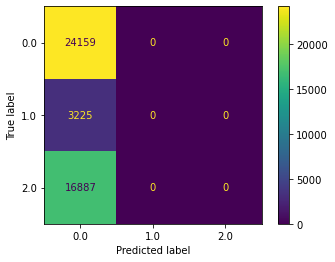

In [51]:
dummy_pipe.class_matrix(X_train, y_train);

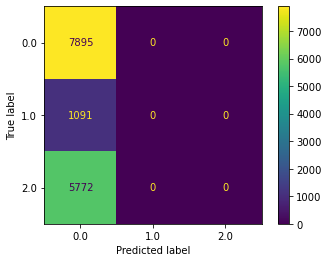

In [52]:
dummy_pipe.class_matrix(X_test, y_test);

C:\Users\nacnu\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nacnu\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Report: 
              precision    recall  f1-score   support

         0.0       0.55      1.00      0.71     24159
         1.0       0.00      0.00      0.00      3225
         2.0       0.00      0.00      0.00     16887

    accuracy                           0.55     44271
   macro avg       0.18      0.33      0.24     44271
weighted avg       0.30      0.55      0.39     44271



Test Report: 
              precision    recall  f1-score   support

         0.0       0.53      1.00      0.70      7895
         1.0       0.00      0.00      0.00      1091
         2.0       0.00      0.00      0.00      5772

    accuracy                           0.53     14758
   macro avg       0.18      0.33      0.23     14758
weighted avg       0.29      0.53      0.37     14758



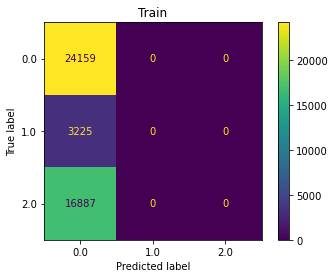

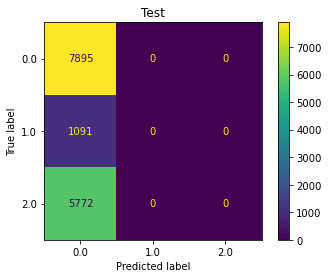

In [148]:
dummy_pipe.run_all(train_results=True);

## LogReg Pipe

In [150]:
log_reg_model = Pipeline([
    ('ColTrans', ColTrans),
    ('logreg', LogisticRegression(random_state=42))
])

In [160]:
log_reg_pipe = ModelRuns(log_reg_model, 'logreg', X_train, y_train)

C:\Users\nacnu\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Report: 
              precision    recall  f1-score   support

         0.0       0.82      0.92      0.87     24159
         1.0       0.71      0.37      0.48      3225
         2.0       0.87      0.79      0.82     16887

    accuracy                           0.83     44271
   macro avg       0.80      0.69      0.72     44271
weighted avg       0.83      0.83      0.82     44271



Test Report: 
              precision    recall  f1-score   support

         0.0       0.76      0.88      0.82      7895
         1.0       0.54      0.22      0.32      1091
         2.0       0.80      0.72      0.76      5772

    accuracy                           0.77     14758
   macro avg       0.70      0.61      0.63     14758
weighted avg       0.76      0.77      0.76     14758



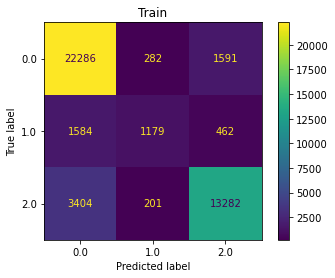

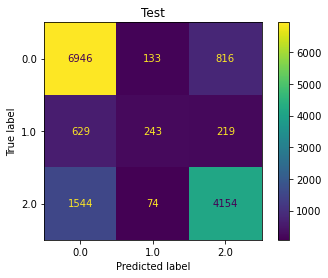

In [161]:
log_reg_pipe.run_all(train_results=True);

## Decision Tree Pipe

In [162]:
dtc_model = Pipeline([
    ('ColTrans', ColTrans),
    ('dtc', DecisionTreeClassifier(random_state=42))
])

In [163]:
dtc_pipe = ModelRuns(dtc_model, 'dtc', X_train, y_train)

Train Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     24159
         1.0       1.00      1.00      1.00      3225
         2.0       1.00      1.00      1.00     16887

    accuracy                           1.00     44271
   macro avg       1.00      1.00      1.00     44271
weighted avg       1.00      1.00      1.00     44271



Test Report: 
              precision    recall  f1-score   support

         0.0       0.80      0.84      0.82      7895
         1.0       0.47      0.34      0.39      1091
         2.0       0.80      0.77      0.78      5772

    accuracy                           0.78     14758
   macro avg       0.69      0.65      0.67     14758
weighted avg       0.77      0.78      0.77     14758



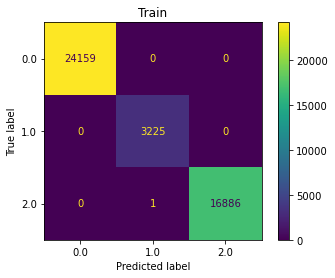

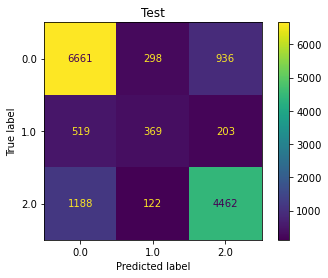

In [164]:
dtc_pipe.run_all(train_results=True);